In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import matplotlib
import cartopy.crs as ccrs # Projections
import cartopy.feature as cfeature
import cartopy
import datetime

In [2]:
sentinel_data_A = pd.read_csv("./Sentinel_3A_water_level_Version0.csv")

In [3]:
sentinel_data_A = sentinel_data_A.rename(
    columns={
        "Date (YYYYMMDD)" : "date",
        "Lake_name" : "lake_name",
        "Latitude" : "latitude",
        "Longitude" : "longitude",
        "Relaive_orbit" : "relative_orbit",
        "Lake water level (m)" : "lake_water_level"
    }
)

In [4]:
sentinel_data_A.head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [5]:
# Isolate Lake Winnipeg data
lake_winnipeg = sentinel_data_A[
    sentinel_data_A["lake_name"] == "Winnipeg"
]

In [6]:
pd.unique(lake_winnipeg[
    lake_winnipeg["relative_orbit"] == pd.unique(lake_winnipeg["relative_orbit"])[0]
]["date"])

array([20160401, 20160428, 20160525, 20160621, 20160718, 20160814,
       20160910, 20161007, 20161103, 20161130, 20161227, 20170123,
       20170219, 20170318, 20170414, 20170511, 20170607, 20170704,
       20170731, 20170827, 20170923, 20171020, 20171116, 20171213,
       20180109, 20180205, 20180304, 20180331, 20180427, 20180620,
       20180717, 20180813, 20180909, 20181006, 20181102, 20181129,
       20181226, 20190122, 20190218, 20190317, 20190510, 20190606,
       20190703, 20190730, 20190826, 20210604, 20210701, 20210728,
       20210824, 20210920])

## Plot ground track along Lake Winnipeg

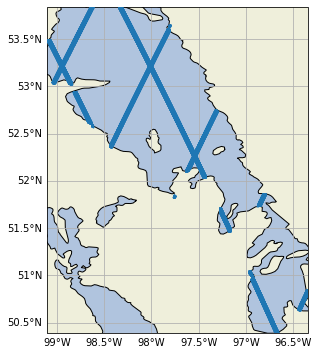

In [7]:
# Get the extent from the data
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# High resolution lakes
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')

# Land, river, and lakes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')

# Plot altimetry points
ax.scatter(
    x=np.array(lake_winnipeg["longitude"]),
    y=np.array(lake_winnipeg["latitude"]),
    zorder=10,
    s=1
)

# Format gridlines
# https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

## Explore Outliers

### Distribution of Water Levels... ignore $\mu\pm2\sigma$?
I sketch the idea below, but I'm not sure it's a good idea to actually implement

In [8]:
lake_water_mean = lake_winnipeg["lake_water_level"].mean()
lake_water_std = lake_winnipeg["lake_water_level"].std()
print("The mean lakewater level is %0.2f and the standard deviation is %02f"%(lake_water_mean, lake_water_std))

The mean lakewater level is 217.27 and the standard deviation is 1.164889


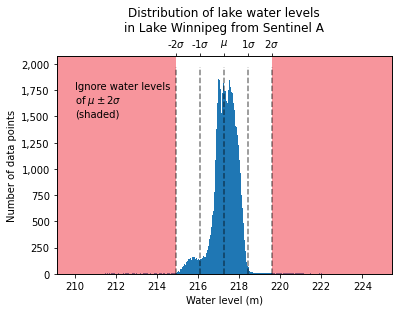

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(
    x=lake_winnipeg["lake_water_level"],
    bins=np.linspace(
        lake_water_mean - 5 * lake_water_std,
        lake_water_mean + 5 * lake_water_std,
        500
    )
)
ax.set_xlim(
    [
        lake_water_mean - 7 * lake_water_std,
        lake_water_mean + 7 * lake_water_std,
    ]
)

ax.axvspan(
    xmin=ax.get_xlim()[0],
    xmax=lake_water_mean - 2 * lake_water_std,
    facecolor="#F02D3A",
    alpha=0.5
)
ax.axvspan(
    xmin=lake_water_mean + 2 * lake_water_std,
    xmax=ax.get_xlim()[1],
    facecolor="#F02D3A",
    alpha=0.5
)


vline_water_levels = [lake_water_mean + i * lake_water_std for i in range(-2,3)]
ax.vlines(
    x=vline_water_levels,
    ymin=ax.get_ylim()[0],
    ymax=ax.get_ylim()[1],
    color='k',
    linestyle='--',
    alpha=0.5
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("Water level (m)")
ax.set_ylabel("Number of data points")

ax1 = ax.twiny()
ax1.set_xlim(
    ax.get_xlim()
)
ax1.set_xticks(
    [lake_water_mean + i * lake_water_std for i in range(-2, 3)]
)
ax1.set_xticklabels(
    [
        r'-2$\sigma$',
        r'-1$\sigma$',
        r'$\mu$',
        r'1$\sigma$',
        r'2$\sigma$',
    ]
)

ax.text(210, 1500, 'Ignore water levels\n' + r'of $\mu  \pm2\sigma$' + '\n(shaded)')
plt.title("Distribution of lake water levels\nin Lake Winnipeg from Sentinel A")
plt.show()

### Water levels in different times of year.
There is ice cover in winter. Take summary stats of winter and non-winter and see how different they are.
I'm not sure this is particularly informative.

In [10]:
lake_winnipeg.head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level
228868,20160401,Winnipeg,51.860057,-96.819518,283,217.4011
228869,20160401,Winnipeg,51.857120,-96.820913,283,217.5197
228870,20160401,Winnipeg,51.854183,-96.822309,283,217.2064
228871,20160401,Winnipeg,51.851245,-96.823704,283,217.3213
228872,20160401,Winnipeg,51.848308,-96.825099,283,217.3166


In [11]:
def add_winter_column(lake_winnipeg):
    # Add a column to indicate if the date is in winter or not.
    lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
    lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
    lake_winnipeg.loc[:, "day"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.day)
    lake_winnipeg.loc[:, "winter"] = ((lake_winnipeg["month"] < 4) | (lake_winnipeg["month"] > 10))
    return lake_winnipeg

def remove_winter_column(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["winter", "month", "day", "date_as_datetime"])
    return lake_winnipeg

In [12]:
lake_winnipeg = add_winter_column(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_19454/2287572897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_19454/2287572897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_

The mean lake water level in winter (Nov - March) is 216.97 m.
The mean lake water level in non-winter (Apr - Oct) is 217.41 m.

In [13]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == True,
    "lake_water_level"
].describe()

count    35584.000000
mean       216.977128
std          1.037623
min        187.942875
25%        216.655480
50%        217.051439
75%        217.488527
max        227.617834
Name: lake_water_level, dtype: float64

In [14]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == False,
    "lake_water_level"
].describe()

count    72920.000000
mean       217.409069
std          1.196905
min        183.408658
25%        217.159186
50%        217.483098
75%        217.780306
max        235.595841
Name: lake_water_level, dtype: float64

In [15]:
#lake_winnipeg = remove_winter_column(lake_winnipeg)

## Errors and Outlier Filtering
### Error: Calculate Absolute Deviance from the Mean (ADM)
Take the median along each track, and then subtract it from all the measurements. Most measurements have an error well below 0.25 m. The DAHITI paper suggest to reject measurements whose ADM is 5 cm. or greater. Perhaps we can be more forgiving and select 25 cm.

In the ideal world, we'd make a sliding box of 1.5 km along each track. We'd calculate the mean in this box and subtract it from the measurement.

Each day seems to be a single track. (See below, play with number_of_tracks. Set it to 1, 2, 3, ...)

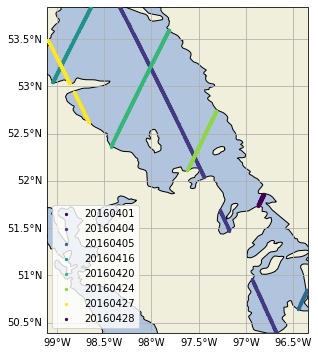

In [16]:
# Change this parameter
number_of_tracks = 8

# Make the cartopy map the background
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Plot altimetry points
number_of_colours = 7
cmap = matplotlib.cm.get_cmap('viridis')
colours = cmap(np.linspace(0, 1, number_of_colours))
for i, date in enumerate(pd.unique(lake_winnipeg["date"])[0:number_of_tracks]):
    ax.scatter(
        x=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "longitude"
        ],
        y=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "latitude"
        ],
        s=5,
        color=colours[i%number_of_colours],
        label=date,
        zorder=10
    )
ax.legend()
plt.show()

In [53]:
def add_adm_error(lake_winnipeg):
    lake_winnipeg["error"] = 0
    unique_dates = pd.unique(lake_winnipeg["date"])
    for date in unique_dates:
        median_water_level = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].median()
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "error"
        ] = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].apply(lambda x: np.abs(x - median_water_level) + 1.)
    return lake_winnipeg

def remove_adm_error(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["error"])
    return lake_winnipeg

In [54]:
lake_winnipeg = add_adm_error(lake_winnipeg)

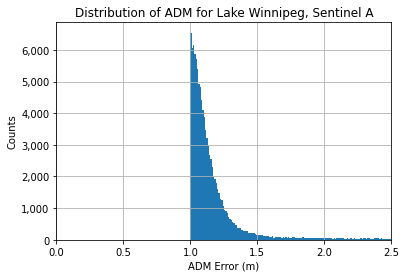

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    lake_winnipeg["error"],
    bins=np.linspace(0, 5, 501)
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("ADM Error (m)")
ax.set_ylabel("Counts")
ax.grid(True)
ax.set_xlim([0, 2.5])
plt.title("Distribution of ADM for Lake Winnipeg, Sentinel A")
plt.show()

### Outliers: Reject $\pm3\sigma$ 
For each track, take the mean and std, and reject points that are outside of $\mu\pm3\sigma$.

In [74]:
lake_winnipeg["mean_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("mean")
lake_winnipeg["std_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("std")
number_of_standard_deviations = 2 # Reject points that are more than number_of_standard_deviation*std from the mean

In [76]:
lake_winnipeg["reject"] = lake_winnipeg.apply(
    lambda row: True if np.abs(
        row["lake_water_level"] - row["mean_track_lake_water_level"]
    ) > number_of_standard_deviations*row["std_track_lake_water_level"] else False,
    axis=1
)

In [77]:
lake_winnipeg["reject"].value_counts()

False    100986
True       3909
Name: reject, dtype: int64

In [78]:
lake_winnipeg = lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
]

# Kalman Filtering

In [79]:
# Work on one time step and then put a loop over time steps

# Model:
# l_k = A_k * x_k - v_k
# There are n=1 grid points on the lake
# There are m_k=42 points on 2016-04-01 and m_k=875 points on 2016-04-04
# Dimensions:
#     l_k: (m_k, 1); lake water observations at time t_k
#     A_k: (m_k, n); ones for each grid point that we have an observation at time t_k
#     x_k: (n, 1); the model state we are after
#     v_k: (m_k, 1); residuals from the observations

# Uncertainty in the lake water level:
# sigma_{ll, k} = I * s_kl
# Dimensions:
#    sigma_{ll, k} = (m_k, m_k); assume each measurement is indepdendent. Diagonal.
#    s_{kl} = (m_k, 1); error in each measurement at time t_k   

In [80]:
class KalmanFilter:
    def __init__(self):
        self.m_t = 0 # number of points in this time step
        self.x_t_prior = 0 # x_t prior, just a #
        self.x_t = 0 # x_t update, just a #
        self.F_t = 0 # transition matrix, just a #
        self.H_t = 0 # model matrix (m_k, 1)
        self.sigma_t_prior = 0 # process noise, prior; just a #
        self.S_t_prior = 0 # observation noise, prior; (m_k, m_k)
        self.sigma_t = 0 # process noise, update; just a #
        self.S_t = 0 # observation noise, update; (m_k, m_k)
        self.y_t_prior = 0 # predictions for observations based on x_t_prior
        self.y_t = 0 # observations; (m_k, 1)
        self.K_t = 0 # Kalman gain
        self.R_t = 0 # Covariance of noise in the observations at time t
        self.Q_t = 0 # Covariance of the noise in...?
        
    def initialize(self, lake_data_0):
        # lake_data_0 is the lake data for the zeroth time step.
        # In our Lake Winnipeg case, it will be something like this;
        # lake_data_0 = lake_winnipeg.loc[
        #    lake_winnipeg["date"] = pd.unique(lake_winnipeg["date"])[0]
        #]
        
        # Initialize the x_t_prior to the lake water level that has the lowest
        # error estimate
        water_level_with_smallest_error = lake_data_0.loc[
            lake_data_0['error'].idxmin()
        ]['lake_water_level']
        self.x_t_prior = water_level_with_smallest_error
        
        # Initialize the process noise to unity
        self.sigma_t_prior = 1.
        
        # Define the variables from the data
        self.input_new_data(lake_data_0)
        
        # Set the transition "matrix"
        self.F_t = 1
        
        # Set the...?
        self.Q_t = 1.0
        
    def input_new_data(self, lake_data):
        # Set the number of points in this time step
        self.m_t = len(lake_data)
        
        # Set the model matrix
        self.H_t = np.ones((self.m_t, 1))
        
        # Set the observation noise matrix.
        self.R_t = np.zeros((self.m_t, self.m_t))
        np.fill_diagonal(self.R_t, lake_data["error"])
        self.S_t_prior = self.R_t + np.matmul(self.H_t, np.transpose(self.H_t)) * self.sigma_t_prior
        
        # Initialize the observations
        self.y_t = np.array(lake_data["lake_water_level"]).reshape(self.m_t, 1)
        
        # Initialize the estimates based on the priors
        self.y_t_prior = self.H_t  * self.x_t_prior
    
    def calculate_kalman_gain(
        self,
        sigma_t_prior, # Process noise, prior
        S_t_prior, # Observation noise, prior
        H_t, # model matrix
    ):
        return np.matmul(
            sigma_t_prior * np.transpose(H_t),
            np.linalg.pinv(S_t_prior)
        )
        
    def update(self):
        self.K_t = self.calculate_kalman_gain(
            self.sigma_t_prior,
            self.S_t_prior,
            self.H_t
        )
        
        # Update state variable
        self.x_t = self.x_t_prior + np.matmul(
            self.K_t,
            self.y_t - self.y_t_prior
        ).item()

        # Update sigma_t
        self.sigma_t = self.sigma_t_prior - np.matmul(
            self.K_t,
            np.matmul(
                self.S_t_prior,
                np.transpose(self.K_t)
            )
        ).item()
    
    def predict(self): # Is a better name predict_next_prior?
        self.x_t_prior = self.x_t
        self.sigma_t_prior = self.sigma_t + self.Q_t

In [81]:
times = pd.unique(lake_winnipeg["date"])
lake_water_levels = np.zeros(np.array(times).shape)
oHai = KalmanFilter()
number_of_time_points = len(times)

for i, time in enumerate(times):
    # Initialize
    if i == 0:
        oHai.initialize(
            lake_winnipeg.loc[
                lake_winnipeg["date"] == time
            ]
        )
    else:
        oHai.input_new_data(
            lake_winnipeg.loc[
                lake_winnipeg["date"] == time
            ]
        )
     # Update
    oHai.update()
    
    # Get the lake water levels
    lake_water_levels[i] = oHai.x_t # This should be a variable like y_k which is just x_k?
    
    oHai.predict()
    
    if (i%100 == 0) or (i == number_of_time_points - 1):
        percentage_complete = i/(number_of_time_points - 1) * 100.
        print("Processing %d, %0.02f%% complete"%(time, percentage_complete))

Processing 20160401, 0.00% complete
Processing 20170418, 29.50% complete
Processing 20180612, 59.00% complete
Processing 20190729, 88.50% complete
Processing 20210924, 100.00% complete


In [82]:
# Form a baseline comparison; take the median on each day, and calculate rms error

def rms(values):
    return np.sqrt(sum(values**2)/len(values))

baseline_results = lake_winnipeg[
    [
        "date",
        "lake_water_level",
        "error"
    ]
].groupby("date").agg(
    {
        "lake_water_level" : "median",
        "error": rms
    }
).reset_index()

baseline_results.loc[:, "date_as_datetime"] = pd.to_datetime(baseline_results.loc[:, "date"], format="%Y%m%d")

In [83]:
baseline_results

,date,lake_water_level,error,date_as_datetime
0,20160401,217.357400,1.051550,2016-04-01
1,20160404,217.420797,1.080877,2016-04-04
2,20160405,217.430868,1.051407,2016-04-05
3,20160416,217.734666,1.077846,2016-04-16
4,20160420,217.686769,1.097875,2016-04-20
...,...,...,...,...
335,20210916,216.917040,1.043210,2021-09-16
336,20210919,216.987893,1.066512,2021-09-19
337,20210920,216.978150,1.071444,2021-09-20
338,20210923,216.852117,1.090071,2021-09-23


In [84]:
time_as_datetime = pd.to_datetime(times, format="%Y%m%d")

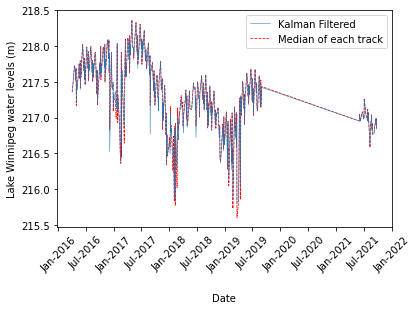

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    time_as_datetime,
    lake_water_levels,
    zorder=10,
    label="Kalman Filtered",
    linewidth=0.5
)
ax.plot(
    baseline_results["date_as_datetime"],
    baseline_results["lake_water_level"],
    'r--',
    linewidth=0.75,
    label="Median of each track"
)
ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Lake Winnipeg water levels (m)')

# Set labels to be every six months
locator = matplotlib.dates.MonthLocator((1, 7))
fmt = matplotlib.dates.DateFormatter('%b-%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)
for x in ax.get_xticklabels():
    x.set_rotation(45)

ax.legend()
plt.show()

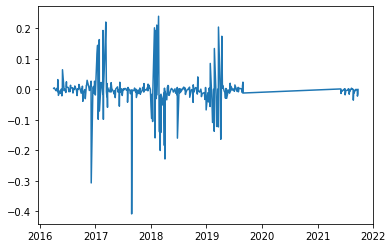

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    time_as_datetime,
    lake_water_levels - baseline_results["lake_water_level"]
)

In [91]:
np.std(lake_water_levels)

0.49098922487207425

In [92]:
np.std(baseline_results["lake_water_level"])

0.4947340994818209

# Other ideas that didn't pan out
### Outliers: Apply Linear SV regression
Along a track of data, apply a linear (flat) SV regression. This gives "wide margin" regression. DAHITI suggests to ignore points that sit outside the margins of +/- 5cm. Perhaps we can be more generous to 25 cm?

Plot the water levels against the longitude coordinate. It seems we can get away with this, since none of our tracks are vertical (i.e. at const longitude)


In [87]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

In [88]:
# Illustrate for one date
date = pd.unique(lake_winnipeg["date"])[0]
X = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ]
).reshape(-1, 1)
y = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
).ravel()
# lin_reg = LinearRegression()
# lin_reg.fit(X, y)
svm_reg = LinearSVR(epsilon=0.05, max_iter=1000, C=1e6)
svm_reg.fit(X, y)

/Users/pvasudev/.virtualenvs/ml-freshwater/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=1000000.0, epsilon=0.05)

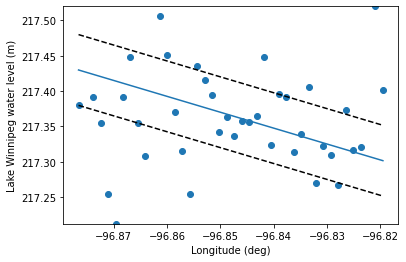

In [89]:
fig = plt.figure()

# Set x-range (i.e. longitude range)
longitude_range = np.linspace(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].min(),
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].max(),
    100
)

water_levels_predicted = svm_reg.predict(longitude_range.reshape(100, 1))
# water_levels_predicted = lin_reg.predict(longitude_range.reshape(100, 1))

ax = fig.add_subplot(111)
ax.plot(longitude_range, water_levels_predicted)
ax.plot(longitude_range, water_levels_predicted - svm_reg.epsilon, "k--")
ax.plot(longitude_range, water_levels_predicted + svm_reg.epsilon, "k--")
ax.scatter(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ],
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
)
ax.set_ylim(
    [
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].min(),
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].max(),
    ]
)
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Lake Winnipeg water level (m)")
plt.show()